In [ ]:

!pip install -q -U transformers datasets evaluate accelerate peft bitsandbytes

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Any, List
from transformers import (
    RobertaTokenizer,
    DataCollatorWithPadding,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import evaluate

# Base models for teacher and student
base_model_teacher = 'roberta-base'
base_model_student = 'roberta-base'

# Load AG News training split
dataset = load_dataset('ag_news', split='train')

tokenizer = RobertaTokenizer.from_pretrained(base_model_teacher)

def preprocess(examples: Dict[str, List[str]]) -> Dict[str, Any]:
    """
    Tokenize a batch of text examples for RoBERTa.

    Args:
              - 'text' (List[str]): raw input strings.

    Returns:
        dict:
            Tokenizer outputs with:
              - 'input_ids' (torch.LongTensor): token IDs padded/truncated to batch max length.
              - 'attention_mask' (torch.LongTensor): mask distinguishing real tokens vs. padding.
    """
    return tokenizer(examples['text'], truncation=True, padding=True)

# Apply tokenization to the dataset and remove the raw text column
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=['text']
)

# Rename label column to 'labels' for compatibility with HuggingFace Trainer
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')

# To determine number of classes and their human-readable names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features['label'].names
print(f"Number of labels: {num_labels}")
print(f"Class names: {class_names}")

# Mapping from label IDs to names (used for model configuration and logging)
id2label = {i: name for i, name in enumerate(class_names)}

# Data collator for dynamic padding at batch time
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

# Split into training and evaluation sets
splits = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = splits['train']
eval_dataset  = splits['test']

/home/vr2470/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of labels: 4
The labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
from typing import Dict
from transformers import EvalPrediction

def compute_metrics(pred: EvalPrediction) -> Dict[str, float]:
    """
    Compute classification accuracy from model predictions.

    Args:
        pred (EvalPrediction):
            An object containing:
              - predictions (np.ndarray or torch.Tensor): model outputs (logits).
              - label_ids (np.ndarray or torch.Tensor): true labels.

    Returns:
        dict:
            A mapping with:
              - 'accuracy' (float): proportion of correct predictions.
    """
    # Extract true labels and predicted class indices
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=-1)
    # To compute accuracy using HuggingFace evaluate library
    accuracy = evaluate.load('accuracy').compute(
        predictions=preds,
        references=labels
    )['accuracy']
    return {'accuracy': accuracy}

In [ ]:
from typing import Dict
from transformers import RobertaForSequenceClassification, TrainingArguments, Trainer

def create_teacher_model(
    base_model: str,
    id2label: Dict[int, str],
    fine_tune: bool = True
) -> RobertaForSequenceClassification:
    """
    Load a RoBERTa sequence classification model as the teacher and optionally fine‑tune it.

    Args:
        base_model (str):
            HuggingFace identifier for the pretrained RoBERTa checkpoint (e.g., 'roberta-base').
        id2label (Dict[int, str]):
            Mapping from label IDs to human-readable class names.
        fine_tune (bool, optional):
            Whether to fine‑tune the model on the AG News dataset. Defaults to True.

    Returns:
        RobertaForSequenceClassification:
            The loaded (and if requested, fine‑tuned) teacher model in evaluation mode.
    """
    # Load pretrained model with custom label mapping
    teacher_model = RobertaForSequenceClassification.from_pretrained(
        base_model,
        id2label=id2label,
        label2id={v: k for k, v in id2label.items()}
    )

    if fine_tune:
        # To set up training arguments for fine‑tuning
        training_args = TrainingArguments(
            output_dir="teacher_results",
            eval_strategy="steps",
            eval_steps=100,
            logging_steps=100,
            save_strategy="steps",
            save_steps=100,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="eval_accuracy",
            greater_is_better=True,
            report_to="none",
            num_train_epochs=2,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            learning_rate=2e-5,
            lr_scheduler_type="linear",
            warmup_ratio=0.1,
            weight_decay=0.01,
            dataloader_num_workers=4,
            optim="adamw_torch",
            label_names=["labels"],
        )

        # Initialize Trainer and fine‑tune
        trainer = Trainer(
            model=teacher_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        trainer.train()
        teacher_model = trainer.model

    teacher_model.eval()
    return teacher_model

In [ ]:
from typing import Dict
from transformers import RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model

def create_student_model(
    base_model: str,
    id2label: Dict[int, str],
    use_lora: bool = True
) -> RobertaForSequenceClassification:
    """
    Load a RoBERTa sequence classification model as the student and optionally wrap it with LoRA adapters.

    Args:
        base_model (str):
            HuggingFace model identifier for the pretrained RoBERTa checkpoint (e.g., 'roberta-base').
        id2label (Dict[int, str]):
            Mapping from label IDs to human-readable class names.
        use_lora (bool, optional):
            If True, applies LoRA adapters for parameter-efficient fine-tuning.
            If False, returns the full model for standard fine-tuning. Defaults to True.

    Returns:
        RobertaForSequenceClassification:
            The student model, wrapped with LoRA adapters if requested, ready for training.
    """
    # Load the base classification model with custom label mapping
    student_model = RobertaForSequenceClassification.from_pretrained(
        base_model,
        id2label=id2label,
        label2id={v: k for k, v in id2label.items()}
    )

    if use_lora:
        # Configure LoRA adapter settings
        peft_config = LoraConfig(
            r=6,
            lora_alpha=16,
            lora_dropout=0.05,
            bias='none',
            target_modules=['query', 'key', 'value'],
            task_type="SEQ_CLS"
        )
        # Wrap model with LoRA adapters
        student_model = get_peft_model(student_model, peft_config)
        # Display count of trainable parameters
        print("Trainable parameters in student model:")
        student_model.print_trainable_parameters()

    return student_model

# Example usage:
teacher_model = create_teacher_model(base_model_teacher, id2label, fine_tune=True)
student_model = create_student_model(base_model_student, id2label, use_lora=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning teacher model...


/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.383500,1.362889,0.459375
200,0.855400,0.374644,0.882812
300,0.329900,0.351394,0.890625
400,0.317400,0.362388,0.881250
500,0.283000,0.298646,0.903125
600,0.289900,0.285448,0.909375
700,0.282500,0.326259,0.901563
800,0.287500,0.315530,0.895312
900,0.263800,0.280159,0.921875
1000,0.271800,0.261474,0.914062


/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_f

Trainable parameters in student model:
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370


In [ ]:
from transformers import Trainer, TrainingArguments
from typing import Dict, Tuple, Any, Union

class DistillationTrainer(Trainer):
    """
    Trainer subclass that performs knowledge distillation from a frozen teacher model.

    Args:
        teacher_model (nn.Module):
            Pretrained teacher whose softened logits provide guidance.
        temperature (float):
            Temperature for distilling logits; higher values produce softer distributions.
        alpha (float):
            Weight for hard-label (cross-entropy) loss. Soft-target distillation loss is weighted by (1 - alpha).
        *args, **kwargs:
            Additional arguments passed to the base Trainer (e.g., model, args, datasets).
    """
    def __init__(
        self,
        teacher_model: nn.Module,
        temperature: float = 2.0,
        alpha: float = 0.5,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        # To freeze and move teacher to the same device as student
        self.teacher = teacher_model.eval().to(self.args.device)
        self.temperature = temperature
        self.alpha = alpha

    def compute_loss(
        self,
        model: nn.Module,
        inputs: Dict[str, torch.Tensor],
        return_outputs: bool = False
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, Any]]:
        """
        Compute combined loss: hard-label cross-entropy + soft-label KL-divergence.

        Args:
            model (nn.Module):
                The student model being trained.
            inputs (dict):
                Batch dict containing input tensors and 'labels'.
            return_outputs (bool):
                If True, also return student model outputs for logging/metrics.

        Returns:
            If return_outputs:
                Tuple of (total_loss, student_model_outputs).
            Else:
                total_loss (torch.Tensor).
        """
        # Forward pass through student
        student_outputs = model(**inputs)
        hard_loss = student_outputs.loss  # CE with true labels

        # Forward pass through teacher
        with torch.no_grad():
            teacher_logits = self.teacher(**inputs).logits

        # Compute distillation (soft-target) loss
        student_log_probs = F.log_softmax(student_outputs.logits / self.temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=-1)
        kl_div = nn.KLDivLoss(reduction="batchmean")
        soft_loss = kl_div(student_log_probs, teacher_probs) * (self.temperature ** 2)

        # Weighted sum of hard and soft losses
        total_loss = self.alpha * hard_loss + (1.0 - self.alpha) * soft_loss

        return (total_loss, student_outputs) if return_outputs else total_loss



# Configure TrainingArguments for distillation
training_args = TrainingArguments(
    output_dir="results_distillation",
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    report_to="none",
    num_train_epochs=2,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=64,
    learning_rate=2e-4,
    lr_scheduler_type="polynomial",
    warmup_ratio=0.1,
    weight_decay=0.01,
    dataloader_num_workers=4,
    optim="adamw_torch",
    label_names=["labels"],
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={"use_reentrant": True}
)

# Initialize distillation trainer with student, teacher, and datasets
trainer = DistillationTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=2.0,
    alpha=0.5
)


# Train the student model using knowledge distillation
print("Training student model with distillation...")
trainer.train()

# Save fine‑tuned student model and tokenizer to disk
output_dir = os.path.join("results_distillation", "student_model")
student_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Student model and tokenizer saved to {output_dir}")

Training student model with distillation...


/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,2.672100,2.626187,0.273438
200,1.931300,0.504374,0.884375
300,0.453600,0.417124,0.903125
400,0.397400,0.366278,0.912500
500,0.380300,0.353874,0.906250
600,0.366900,0.362006,0.910937
700,0.362600,0.365793,0.901563
800,0.320600,0.388265,0.892188
900,0.306900,0.302425,0.915625
1000,0.285000,0.292000,0.914062


/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/vr2470/.local/lib/python3.9/site-packages/torch/nn/parallel/_f

Student model saved.


In [ ]:
student_model.print_trainable_parameters()

trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370


In [ ]:
print(student_model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import AutoTokenizer, RobertaForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import pickle
from peft import PeftModel, PeftConfig

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# To define the evaluate_model function
def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

# Initialize tokenizer
student_model_path = "results_distillation/student_model"
tokenizer = AutoTokenizer.from_pretrained(student_model_path)

# Load the PEFT student model
try:
    config = PeftConfig.from_pretrained(student_model_path)
    base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
    inference_model = PeftModel.from_pretrained(base_model, student_model_path)
    print("Loaded PEFT student model from:", student_model_path)
except Exception as e:
    print(f"Failed to load PEFT student model: {e}")
    # Fallback to roberta-base (not recommended)
    inference_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
    print("Loaded standard Roberta model (not fine-tuned). Predictions may be unreliable.")


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Load unlabeled dataset
with open("test_unlabelled.pkl", "rb") as f:
    unlabelled_data = pickle.load(f)

if isinstance(unlabelled_data, Dataset):
    unlabelled_dataset = unlabelled_data
else:
    unlabelled_dataset = Dataset.from_pandas(unlabelled_data)


test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])

# Set format for PyTorch tensors
test_dataset.set_format("torch")

# Define output directory
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Run inference and save predictions
preds = evaluate_model(inference_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()
})
df_output.to_csv(os.path.join(output_dir, "inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded PEFT student model from: results_distillation/student_model


100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]

Inference complete. Predictions saved to inference_output.csv


In [ ]:
import os
print(os.listdir("results_distillation/student_model"))

['adapter_model.safetensors', 'merges.txt', 'adapter_config.json', 'README.md', 'vocab.json', 'tokenizer_config.json', 'special_tokens_map.json']


In [ ]:
steps = list(range(100, 7501, 100))
training_loss = [
    2.6721, 1.9313, 0.4536, 0.3974, 0.3803, 0.3669, 0.3626, 0.3206, 0.3069, 0.285,
    0.2843, 0.2529, 0.23, 0.2442, 0.2289, 0.2246, 0.2152, 0.1857, 0.2038, 0.2078,
    0.1861, 0.1915, 0.1953, 0.1884, 0.1972, 0.1844, 0.1817, 0.1771, 0.1767, 0.1771,
    0.1782, 0.1627, 0.1522, 0.1493, 0.1623, 0.1685, 0.1533, 0.1532, 0.1414, 0.1469,
    0.1608, 0.1281, 0.1503, 0.1543, 0.1335, 0.1502, 0.1437, 0.1361, 0.1485, 0.1471,
    0.1516, 0.1384, 0.1307, 0.1478, 0.145, 0.1256, 0.1274, 0.1406, 0.1336, 0.1362,
    0.1271, 0.1384, 0.1315, 0.1296, 0.1301, 0.1438, 0.1297, 0.1282, 0.1303, 0.1424,
    0.1264, 0.1209, 0.1364, 0.1174
]

validation_loss = [
    2.626187, 0.504374, 0.417124, 0.366278, 0.353874, 0.362006, 0.365793, 0.388265, 0.302425, 0.292,
    0.291396, 0.221213, 0.212055, 0.21957, 0.216148, 0.211055, 0.191892, 0.201469, 0.189312, 0.185762,
    0.178847, 0.177134, 0.166077, 0.163686, 0.149736, 0.167264, 0.165233, 0.14892, 0.16601, 0.164669,
    0.174942, 0.155451, 0.161412, 0.165395, 0.157361, 0.154065, 0.153372, 0.160324, 0.147909, 0.148714,
    0.146556, 0.156945, 0.150423, 0.14926, 0.145107, 0.158342, 0.148978, 0.144738, 0.150293, 0.149499,
    0.144714, 0.151131, 0.154481, 0.144397, 0.145989, 0.144907, 0.147813, 0.1427, 0.144789, 0.144498,
    0.141956, 0.145303, 0.145813, 0.14248, 0.142469, 0.141934, 0.141846, 0.141156, 0.140424, 0.140162,
    0.139933, 0.141462, 0.141272, 0.140326
]

accuracy = [
    0.273438, 0.884375, 0.903125, 0.9125, 0.90625, 0.910937, 0.901563, 0.892188, 0.915625, 0.914062,
    0.917188, 0.917188, 0.929688, 0.925, 0.921875, 0.91875, 0.91875, 0.921875, 0.929688, 0.928125,
    0.921875, 0.925, 0.926562, 0.926562, 0.93125, 0.928125, 0.925, 0.934375, 0.93125, 0.929688,
    0.923438, 0.93125, 0.93125, 0.928125, 0.928125, 0.935937, 0.93125, 0.928125, 0.93125, 0.934375,
    0.939063, 0.929688, 0.932813, 0.929688, 0.93125, 0.93125, 0.93125, 0.932813, 0.929688, 0.93125,
    0.928125, 0.93125, 0.929688, 0.934375, 0.932813, 0.932813, 0.932813, 0.935937, 0.934375, 0.93125,
    0.935937, 0.934375, 0.93125, 0.935937, 0.934375, 0.9375, 0.934375, 0.935937, 0.934375, 0.932813,
    0.93125, 0.932813, 0.932813, 0.932813
]


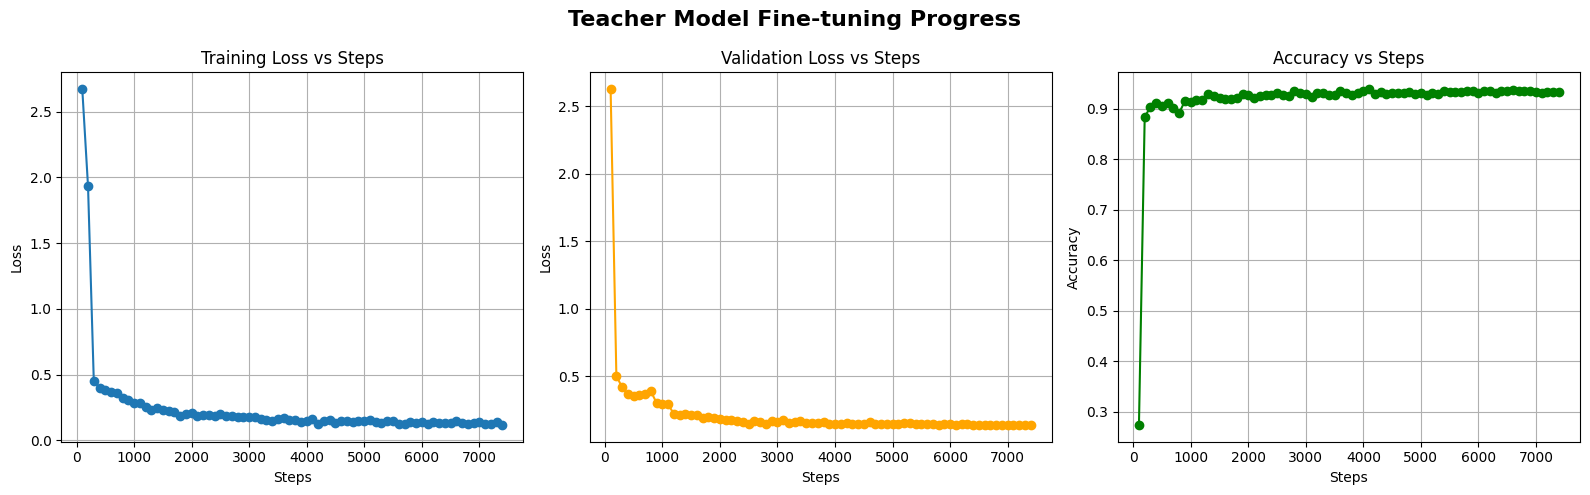

In [ ]:
import matplotlib.pyplot as plt

steps = steps[:74]

# Re-plotting
plt.figure(figsize=(16, 5))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs Steps")
plt.grid(True)

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(steps, validation_loss, label='Validation Loss', color='orange', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss vs Steps")
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(steps, accuracy, label='Accuracy', color='green', marker='o')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Steps")
plt.grid(True)

plt.suptitle("Teacher Model Fine-tuning Progress", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
steps = list(range(100, 7501, 100))

training_loss = [
    1.3835, 0.8554, 0.3299, 0.3174, 0.2830, 0.2899, 0.2825, 0.2875, 0.2638, 0.2718,
    0.2373, 0.2307, 0.2261, 0.2267, 0.2115, 0.2218, 0.2015, 0.2089, 0.1793, 0.2107,
    0.2054, 0.1854, 0.1955, 0.1893, 0.1927, 0.1862, 0.1526, 0.1876, 0.1989, 0.1775,
    0.1691, 0.1856, 0.1833, 0.1880, 0.1713, 0.1722, 0.1856, 0.1651, 0.1537, 0.1573,
    0.1469, 0.1376, 0.1440, 0.1587, 0.1680, 0.1445, 0.1441, 0.1379, 0.1489, 0.1280,
    0.1264, 0.1464, 0.1426, 0.1542, 0.1322, 0.1325, 0.1348, 0.1228, 0.1234, 0.1520,
    0.1299, 0.1240, 0.1097, 0.1560, 0.1262, 0.1430, 0.1097, 0.1149, 0.1317, 0.1314,
    0.1249, 0.1285, 0.1418, 0.1366
]

validation_loss = [
    1.362889, 0.374644, 0.351394, 0.362388, 0.298646, 0.285448, 0.326259, 0.315530, 0.280159, 0.261474,
    0.242128, 0.287348, 0.260120, 0.223241, 0.257859, 0.227898, 0.224977, 0.217438, 0.215944, 0.224245,
    0.215663, 0.209348, 0.206154, 0.226755, 0.195918, 0.209396, 0.235184, 0.188811, 0.191705, 0.187644,
    0.198806, 0.193099, 0.201395, 0.195636, 0.204855, 0.211552, 0.194755, 0.200118, 0.190888, 0.195613,
    0.188665, 0.191207, 0.209504, 0.191329, 0.192055, 0.185555, 0.186556, 0.186888, 0.193319, 0.194134,
    0.203219, 0.197350, 0.192522, 0.186145, 0.190997, 0.180158, 0.185574, 0.187298, 0.193100, 0.184313,
    0.190708, 0.194107, 0.193748, 0.185609, 0.173903, 0.173554, 0.177297, 0.177729, 0.170793, 0.172813,
    0.167628, 0.168687, 0.168701, 0.169142
]

accuracy = [
    0.459375, 0.882812, 0.890625, 0.881250, 0.903125, 0.909375, 0.901563, 0.895312, 0.921875, 0.914062,
    0.918750, 0.904687, 0.921875, 0.923438, 0.929688, 0.929688, 0.937500, 0.939063, 0.940625, 0.935937,
    0.946875, 0.935937, 0.937500, 0.928125, 0.935937, 0.935937, 0.928125, 0.945312, 0.943750, 0.948438,
    0.939063, 0.945312, 0.945312, 0.937500, 0.940625, 0.917188, 0.935937, 0.942187, 0.937500, 0.942187,
    0.946875, 0.940625, 0.943750, 0.939063, 0.946875, 0.945312, 0.945312, 0.946875, 0.939063, 0.942187,
    0.951562, 0.950000, 0.943750, 0.943750, 0.945312, 0.945312, 0.943750, 0.940625, 0.945312, 0.948438,
    0.945312, 0.945312, 0.943750, 0.943750, 0.942187, 0.945312, 0.948438, 0.946875, 0.946875, 0.948438,
    0.946875, 0.948438, 0.946875, 0.948438
]

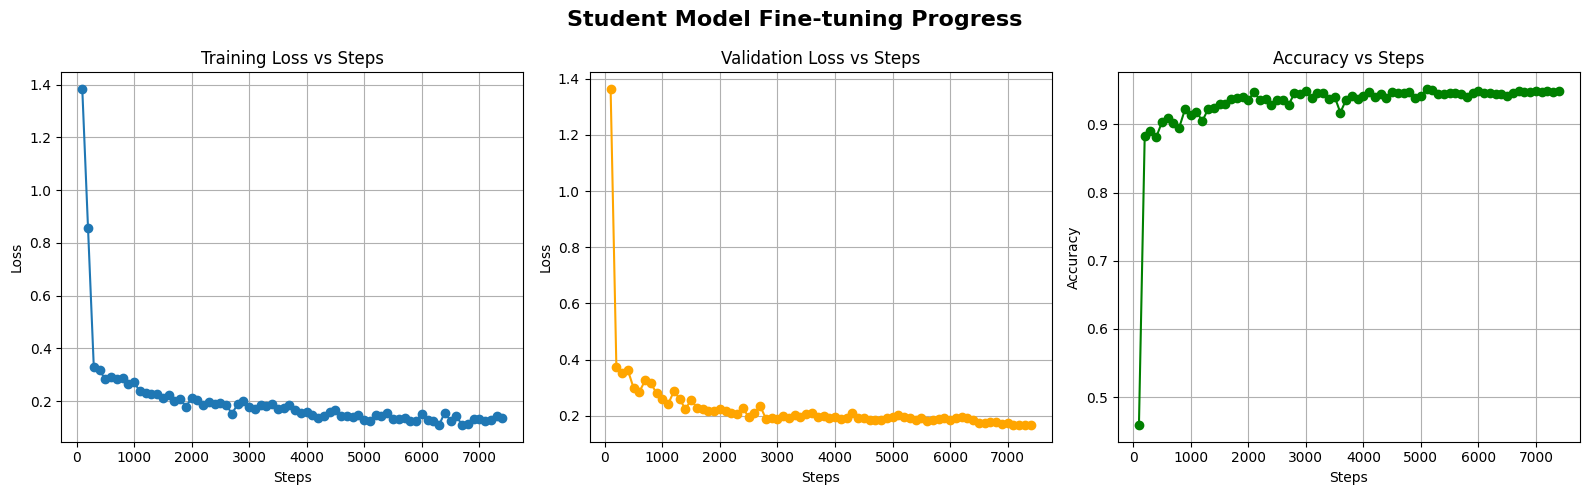

In [ ]:
steps = steps[:74]

# Re-plotting
plt.figure(figsize=(16, 5))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(steps, training_loss, label='Training Loss', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs Steps")
plt.grid(True)

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(steps, validation_loss, label='Validation Loss', color='orange', marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss vs Steps")
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(steps, accuracy, label='Accuracy', color='green', marker='o')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Steps")
plt.grid(True)

plt.suptitle("Student Model Fine-tuning Progress", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()